In [1]:
import torch
from torch import nn
import numpy as np
from dataclasses import dataclass

from matplotlib import pyplot as plt

from my_mamba import Mamba, MambaConfig

In [2]:
import torch
from torch import nn
from dataclasses import dataclass

@dataclass
class MyMambaConfig:
    in_dict_size: int   # число допустимых входных токенов
    out_dict_size: int  # число допустимых выходных токенов
    # mamba_params: dict  # словарь, передаваемый в конструктор mamba 
    mamba_config: MambaConfig

@dataclass
class MyCaseConfig:
    name: str
    description: str

    mamba_config: MyMambaConfig # полное описание главной модели (mamba)
    generate_sample: int   # функция для генерации одного сэмпла (возвращает последовательность, целевые метки классов на выходе, и важность каждого входного токена)
    batch_size: int     # после генерации сэмплы объединяются в батчи такого размера

    # auxiliary_per_layer_classes: list
    # auxiliary_model_classes: list  # классы моделей, принимающих все delta из слоёв mamba, и возвращающих важности каждого токена

    tokens_per_training_epoch: int  # число важных токенов, необходимое для завершения одной эпохи обучения и подсчёта статистики
    validation_tokens: int  # число важных токенов, на которых проводится валидация (эти сэмплы генерируются один раз в начале случайно)
    validate_every_n_epochs: int  # раз в сколько тренировочных эпох надо валидироваться
    n_training_epochs: int

    # сиды генерации для воспроизводимости
    numpy_seed: int = None
    torch_seed: int = None


@dataclass
class MyLossesLogs:
    train_losses: list
    val_losses: list


@dataclass
class MyCaseLogs:
    case_config: MyCaseConfig
    model: nn.Module

    # лоссы при обучении по эпохам (для графиков)
    mamba_losses_logs: MyLossesLogs
    # auxiliary_per_layer_logs: list
    # auxiliary_losses_logs: list

    # последние батчи (для просмотра их глазами)
    last_train_batch: torch.Tensor = None
    last_val_batch: torch.Tensor = None



class MyCase:
    def set_seeds(config: MyCaseConfig):
        """ 
        расставляет сиды генерации в конфигурацию эксперимента для воспроизводимости
        """
        if config.numpy_seed == None:
            config.numpy_seed = np.random.seed
        else: 
            assert isinstance(config.numpy_seed, int)
            np.random.seed = config.numpy_seed

        if config.torch_seed == None:
            config.torch_seed = torch.seed()
        else: 
            assert isinstance(config.torch_seed, int)
            torch.seed(config.torch_seed)


    def create_model(config):
        D, M, N_in, N_out = MyCase.get_dimensions(config)
        model = nn.Sequential(
            nn.Embedding(N_in, D),
            Mamba(config.mamba_config.mamba_config),
            nn.Linear(D, N_out)
        )
        opt = torch.optim.Adam(model.parameters(), lr=1e-2)
        return model, opt
    

    def generate_batch(config, device=None):
        # in_seq, out_mask, out_seq, importance_mask = config.generate_sample()
        # assert len(in_seq) == len(out_mask)
        # assert len(in_seq) == len(importance_mask)
        samples = [config.generate_sample() for _ in range(config.batch_size)]
        batch = tuple([torch.tensor(np.stack(arr)) for arr in zip(*samples)])
        if device is not None:
            batch = MyCase.batch_to(batch, device)
        return batch
        
    
    def create_validation_dataset(config: MyCaseConfig, device=None):
        val_batches = []
        val_tokens = 0
        while val_tokens < config.validation_tokens:
            batch = MyCase.generate_batch(config, device)
            val_batches.append(batch)
            in_seq, out_mask, out_seq, importance_mask = batch
            val_tokens += out_mask.sum()
        return val_batches
    

    def get_dimensions(config):

        D = config.mamba_config.mamba_config.d_model
        M = config.mamba_config.mamba_config.n_layers

        N_in = config.mamba_config.in_dict_size
        N_out = config.mamba_config.out_dict_size
        return D, M, N_in, N_out


    def batch_to(batch, device):
        return tuple([arr.to(device) for arr in batch])
    

    def train_epoch(model, opt, config: MyCaseConfig, logs: MyCaseLogs, device):
        D, M, N_in, N_out = MyCase.get_dimensions(config)
        B = config.batch_size

        train_tokens = 0
        train_losses = []
        while train_tokens < config.tokens_per_training_epoch:
            batch = MyCase.generate_batch(config, device)
            in_seq, out_mask, out_seq, importance_mask = batch

            L = in_seq.size(1)  # длина последовательностей в этом батче
            for t in batch:     # каждый из тензоров in_seq, out_mask, out_seq, importance_mask должен иметь размер (B, L)
                assert tuple(t.shape) == (B, L)

            # получаем предсказания модели
            pred = model(in_seq)  # (B, L, N_out)

            assert tuple(pred.shape) == (B, L, N_out), (tuple(pred.shape), (B, L, N_out))

            losses = nn.CrossEntropyLoss(reduction='none')(pred.transpose(1, 2), out_seq)
            assert tuple(losses.shape) == (B, L), (tuple(losses.shape), (B, L))

            loss = torch.where(out_mask != 0, losses, 0).sum()
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_tokens += out_mask.sum()
            train_losses.append(loss.detach().cpu().item())

        logs.last_train_batch = batch
        logs.mamba_losses_logs.train_losses.append(np.sum(train_losses)/train_tokens)


    def val_epoch(model, val_batches, config: MyCaseConfig, logs: MyCaseLogs, device):
        D, M, N_in, N_out = MyCase.get_dimensions(config)
        B = config.batch_size

        val_tokens = 0
        val_losses = []
        for batch in val_batches:
            in_seq, out_mask, out_seq, importance_mask = batch

            L = in_seq.size(1)  # длина последовательностей в этом батче
            for t in batch:     # каждый из тензоров in_seq, out_mask, out_seq, importance_mask должен иметь размер (B, L)
                assert tuple(t.shape) == (B, L)

            # получаем предсказания модели
            pred = model(in_seq)  # (B, L, N_out)
            assert tuple(pred.shape) == (B, L, N_out)

            losses = nn.CrossEntropyLoss(reduction='none')(pred.transpose(1, 2), out_seq)
            assert tuple(losses.shape) == (B, L)

            loss = torch.where(out_mask != 0, losses, 0).sum()

            val_tokens += out_mask.sum()
            val_losses.append(loss.detach().cpu().item())

        logs.last_val_batch = val_batches[-1]
        logs.mamba_losses_logs.val_losses.append(np.sum(val_losses)/val_tokens)


    def train(config: MyCaseConfig, device=None) -> MyCaseLogs:

        # запоминаем или загружаем сиды numpy и torch для воспроизводимости
        MyCase.set_seeds(config)

        # создаём модель и оптимизатор исходя из конфигурации
        model, opt = MyCase.create_model(config)

        # определяем устройство для обучения и переносим всё на него
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)

        # генерируем тестовый датасет
        val_batches = MyCase.create_validation_dataset(config, device)

        # создаём объект для хранения логов (метрики во время обучения и прочее)
        logs = MyCaseLogs(config, model, MyLossesLogs([], []))

        # начинаем обучение по эпохам
        for _ in range(config.n_training_epochs):
            MyCase.val_epoch(model, val_batches, config, logs, device)
            print('val_epoch', logs.mamba_losses_logs.val_losses[-1])

            for _ in range(config.validate_every_n_epochs):
                MyCase.train_epoch(model, opt, config, logs, device)
                print('train_epoch', logs.mamba_losses_logs.train_losses[-1])
                if logs.mamba_losses_logs.train_losses[-1] < 1e-4:
                    break
                
            if logs.mamba_losses_logs.train_losses[-1] < 1e-4:
                    break

        MyCase.val_epoch(model, val_batches, config, logs, device)
        print('val_epoch', logs.mamba_losses_logs.val_losses[-1])

        return logs
    

def generate_selective_copying_sample(l, k, n) -> np.ndarray:
    in_seq, out_mask, out_seq, importance_mask = (np.zeros(l+k, dtype=int) for _ in range(4))

    idx = np.sort(np.random.permutation(l)[:k])
    res_seq = np.random.randint(0, n, size=k)

    in_seq[:l] = n
    in_seq[l:] = n+1
    in_seq[idx] = res_seq

    out_mask[:] = 0
    out_mask[l-1:l+k-1] = 1

    out_seq[l-1:l+k-1] = res_seq

    importance_mask[:] = 0
    importance_mask[idx] = 1

    return in_seq, out_mask, out_seq, importance_mask


def generate_induction_heads_sample(l, k, n) -> np.ndarray:
    in_seq, out_mask, out_seq, importance_mask = (np.zeros(l+k, dtype=int) for _ in range(4))


    idx = np.random.randint(l-k-1)

    in_seq[:l] = np.random.randint(n, size=l)
    in_seq[idx] = n
    in_seq[l:] = n+1

    out_mask[:] = 0
    out_mask[l-1:l+k-1] = 1

    out_seq[l-1:l+k-1] = in_seq[idx+1:idx+1+k]

    importance_mask[:] = 0
    importance_mask[idx+1:idx+1+k] = 1

    return in_seq, out_mask, out_seq, importance_mask


In [3]:
B, L, K, N = 32, 8, 1, 2

case_config = MyCaseConfig(
    name='simple', 
    description='',
    mamba_config=MyMambaConfig(
        in_dict_size=N+2,
        out_dict_size=N,
        mamba_config=MambaConfig(
            d_model=16,
            n_layers=1,
            d_conv=4,
        )
    ),
    generate_sample=lambda: generate_selective_copying_sample(l=L, k=K, n=N),
    batch_size=B,
    tokens_per_training_epoch=10000,
    validation_tokens=10000,
    validate_every_n_epochs=5,
    n_training_epochs=10
)

# logs = MyCase.train(case_config)

logs = MyCase.train(case_config)

val_epoch tensor(0.7869)
train_epoch tensor(0.0440)
train_epoch tensor(2.6466e-06)
val_epoch tensor(1.4894e-06)


torch.Size([32, 9, 1, 32])
torch.Size([32, 9, 1, 1])
tensor([2, 2, 2, 2, 0, 2, 2, 2, 3])


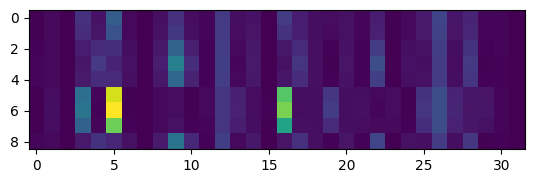

In [4]:
import sklearn.metrics as metrics

batch = MyCase.generate_batch(case_config)
model = logs.model
mamba = model[1]

preds = model(batch[0])

deltas = mamba.get_logs('delta')
pred_deltas = mamba.get_logs('pred_delta')

print(deltas.shape)
print(pred_deltas.shape)

print(batch[0][0])
plt.imshow(deltas[0, :, :, :].detach().reshape((L+K, -1)))

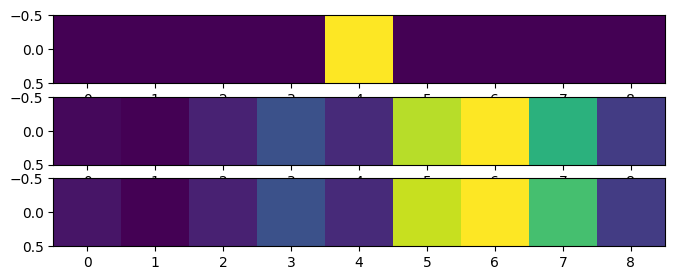

In [5]:
rows, cols = 3, 1
_, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(10*cols, 1*rows), squeeze=False)

axs[0, 0].imshow(batch[3][0][None, :])
axs[1, 0].imshow(deltas[0, :, :, :].detach().reshape((L+K, -1)).mean(dim=1)[None, :])
axs[2, 0].imshow(torch.max(deltas[0, :, :, :].detach().reshape((L+K, -1)),dim=1).values[None, :])

ROC-AUC=0.2767333984375


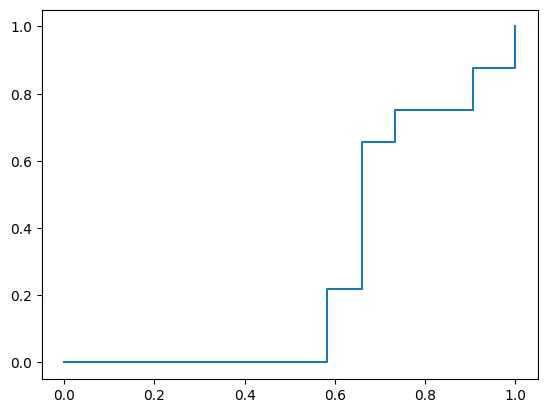

In [6]:
y_true = batch[3].flatten().detach()
y_pred = deltas.mean(dim=(2,3)).flatten().detach()

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)

plt.plot(fpr, tpr)
print(f'ROC-AUC={metrics.roc_auc_score(y_true, y_pred)}')

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Данные: X (n_samples, n_features), y (0 или 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, y_train = pred_deltas.detach().reshape((B*(L+K), -1)).numpy(), batch[3].flatten().detach().numpy()

new_batch = MyCase.generate_batch(case_config)

preds = model(new_batch[0])
new_deltas = mamba.get_logs('delta')
new_pred_deltas = mamba.get_logs('pred_delta')
X_test, y_test = new_pred_deltas.detach().reshape((B*(L+K), -1)).numpy(), new_batch[3].flatten().detach().numpy()

# Создаём датасет для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Параметры (можно настроить через optuna/hyperopt)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1
}

# Обучение
boost_model = lgb.train(params, train_data, num_boost_round=100)

# Предсказание
y_pred = (boost_model.predict(X_test) > 0.5).astype(int)
print(f"Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)

plt.plot(fpr, tpr)

RuntimeError: shape '[256, -1]' is invalid for input of size 288